<a href="https://colab.research.google.com/github/tommylouistaylor/GEOG0051_DataMining_MobilityAnalysis/blob/master/GEOG0051_Coursework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GEOG0051: Mining Social and Geographic Datasets
-----------------------------------
Mobility Patterns Analysis in Cambridge
-------------------------------
Tommy Taylor

In [ ]:
# install packages
!pip install geopandas
!pip install osmnx
!pip install statsmodels
!pip install spint
!pip install contextily
!pip install matplotlib==3.1.3
!pip install matplotlib-scalebar
!pip install -U scikit-learn

In [4]:
# built-in
import time
from datetime import datetime
from IPython.display import IFrame    # for embedding an HTML iframe into the IPython notebook

# numeric
import numpy as np                    # for working with datasets as arrays/matrices
import pandas as pd                   # for working with datasets as dataFrames/Series) - based on NumPy.
import geopandas as gpd               # for working with geospatial data as dataFrames/Series - based on pandas

# networks
import networkx as nx                 # for creating networts
import osmnx as ox                    # for retrieving datasets (incl networks) from OSM
 
# visualising
import matplotlib
import matplotlib.pyplot as plt       # for plotting data onto a graph figure
import matplotlib.cm as cm            # for accessing built-in colormaps and utilities
import matplotlib.colors as colors    # for converting converting numbers to RGB
import seaborn as sns                 # for plotting statistical graphs. Built on Matplotlib and integrated with pandas data structures.
import folium                         # for visualising data on a Leaflet map
import folium.plugins
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import contextily as ctx              # for visualising data on a retrieved basemap of web tiles. Works with GeoPandas/Rasterio


---

**2.2.1 Visualise individual check-in locations** </br>
Visualise the check-in locations of the GC dataset for users with User IDs [75027] and [102829] using the Folium library.
Comment briefly on your findings of the locations visited by the 2 users, using any library that enables mapping. You should also comment briefly on the privacy implications of this type of analysis. [Note: This task primarily serves to help familiarise you with the dataset; we advise not to spend too long on it.]



In [5]:
# LOAD DATASET INTO PANDAS DF:
def read_csv(dataset):
  df = pd.read_csv(datasetURL, index_col='ID')                            # stores dataset in Pandas dataframe structure
  # datetime formatting
  df['date'] = pd.to_datetime(df['date'],  dayfirst=True).astype(str)     # converts date series to UK formatted timedate, then to string.
  df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S' ).dt.time.astype(str)
  df['date_time'] = pd.to_datetime(df["date"].map(str) +'-'+ df["Time"])  # concatenate date and time series
  df = df.drop(columns=['date', 'Time'])
  # df.info() # optional technical summary:
  return df
  
datasetURL = 'https://raw.githubusercontent.com/tommylouistaylor/GEOG0051_DataMining_MobilityAnalysis/master/Data/Cambridge_gowalla.csv?token=GHSAT0AAAAAABWK6A6RSMNTSKQ2M7J7ADTEYWZS6VQ'
df = read_csv(datasetURL)

# CONVERT PANDAS DF INTO GEOPANDAS GDF:
def df_to_gdf(df):
  gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat)) # creates gdf with geometry series
  gdf = gdf[['User_ID','loc_ID','lat','lon', 'geometry', 'date_time']]    # rearrange column ordering
  gdf_geog = gdf.set_crs(epsg=4326)                                       # set g-crs to WGS84 for rendering in Folium
  # gdf_geog = gdf_geog.drop(columns=['lon', 'lat'])
  gdf_proj = gdf_geog.to_crs(epsg=3857)                                   # set p-crs to Web Mercator for rendering with Contextily basemaps
  return gdf_geog, gdf_proj
  
gdf_geog, gdf_proj = df_to_gdf(df)
# print("gdf_geog: \n", gdf_geog.to_string())
# print("gdf_proj: \n", gdf_proj.to_string())

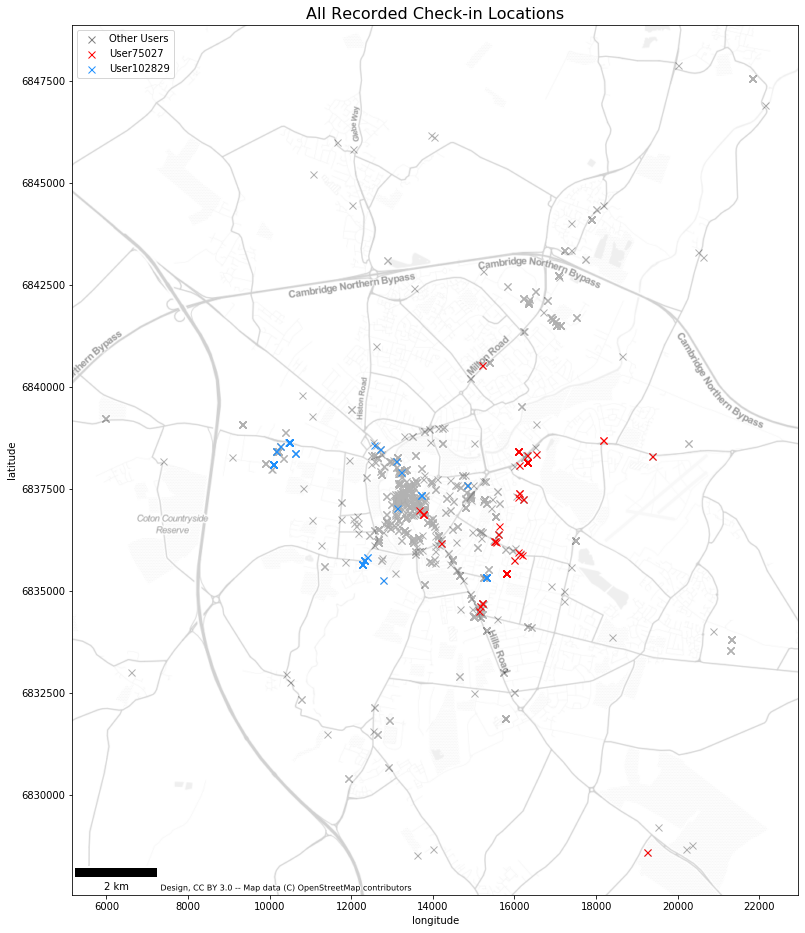

In [6]:
# CHECK-IN PLOT: LIST-LOOP METHOD

# CREATE LIST OF USER_IDs & GEOMETRIES:
def gdf_to_lists(gdf):
  userID_list = gdf['User_ID'].tolist()
  geometry_list = [(point.xy[1][0], point.xy[0][0]) for point in gdf.geometry ]
  datetime_list = gdf['date_time'].tolist()
  return userID_list, geometry_list, datetime_list

userID_list, geometry_list_proj, datetime_list = gdf_to_lists(gdf_proj)  # for geographical plot w/ contextily
userID_list, geometry_list_geog, datetime_list = gdf_to_lists(gdf_geog)  # for folium map

# RUN PLOTTER
def geog_plot(geometry_list, userID_list):
  # create empty grid
  figure = plt.figure(figsize=(16,16)) # create figure
  ax = figure.add_subplot(111)         # add plot to figure
  plt.xlabel('longitude')
  plt.ylabel('latitude')
  plt.title("All Recorded Check-in Locations", fontsize=16)
  plt.rcParams['figure.facecolor'] = 'lightgrey'
  from matplotlib_scalebar.scalebar import ScaleBar
  ax.add_artist(ScaleBar(1, location='lower left'))
  # fit points onto grid: 
  for point, user in zip(geometry_list, userID_list):
    if user == 75027:
      plt.plot(point[1], point[0], "gx", markersize=7, color="red", label="User75027", zorder=1)
    elif user == 102829:
      plt.plot(point[1], point[0], "rx", markersize=7, color="dodgerblue", label="User102829", zorder=2)
    else:
      plt.plot(point[1], point[0], "kx", markersize=7, color="gray", label="Other Users", zorder=0)
  # add basemap:
  ctx.add_basemap(ax, alpha=0.4, source=ctx.providers.Stamen.TonerLite)
  # add legend:
  handles, labels = plt.gca().get_legend_handles_labels()
  from collections import OrderedDict
  by_label = OrderedDict(zip(labels, handles))
  plt.legend(by_label.values(), by_label.keys())
  plt.show()

geog_plot(geometry_list_proj, userID_list)

In [7]:
# CREATE FOLIUM MAP
# inspiration: https://geopandas.readthedocs.io/en/latest/gallery/plotting_with_folium.html

def create_checkin_map(gdf, userID_list, datetime_list, geometry_list):
  # initialise map object
  my_map = Map([gdf['geometry'].y.mean(), gdf['geometry'].x.mean()], tiles='OpenStreetMap', zoom_start=13) # initialises map object with appropriate centre, tiles & zoom-level
  
  # first child: point markers
  for user, datetime, point in zip(userID_list, datetime_list, geometry_list): # loop through multiple lists sequentially
    if user == 75027:
      type_color = "red"
    elif user == 102829:
      type_color = "blue"
    else:
      continue
    
    my_map.add_child(folium.Marker(location = point, icon = folium.Icon(color= "%s" % type_color, icon='user', prefix='fa'), popup =
                              "User: " + '<br>' + str(user) + '<br> <br>'
                              "DateTime: " + '<br>' + str(datetime) + '<br> <br>'
                              "Lat: " + '<br>' + str(point[0]) + '<br>'
                              "Long: " + '<br>' + str(point[1]) + '<br>'
                              )) # Place the markers with the popup labels and data.

  # second child: heatmap
  from folium import plugins
  heat_map = folium.Map([gdf['geometry'].y.mean(), gdf['geometry'].x.mean()])
  geometry_list = [[point.xy[1][0], point.xy[0][0]] for point in gdf.geometry ]
  plugins.HeatMap(geometry_list).add_to(my_map) # add Heatmap to my_map

  return my_map 

my_map = create_checkin_map(gdf_geog, userID_list, datetime_list, geometry_list_geog)

my_map # show map

---
**2.2.2 Provide Characterisation of the Gowalla dataset**

Provide a characterisation of the data available for the user [75027] on 30/01/2010 and for user [102829] on 11/05/2010, by 1) visualising the paths for both users using the OSMnx library. Then 2) summarising your answers in a table in your report and compute, for each user:
*   maximum displacement (maximum distance between two consecutive locations they moved between);
*   average displacement (average distance between two consecutive locations/check-ins);
*   total distance travelled on the day;

Note: distances should be described in network distance (distances of paths along the street networks, rather than geographical distances - are there disadvantages to this?)


In [8]:
# SELECT GDF SUBSET BY USER_ID:
def select_by_userID(gdf, user):
  if gdf['User_ID'].dtype == np.int64:
    gdf_user = gdf[gdf['User_ID'] == user]
    return gdf_user
  else:
    print("this function only supports data formatted as int64")

gdf_geog_u75027 = select_by_userID(gdf_geog, 75027)
gdf_geog_u102829 = select_by_userID(gdf_geog, 102829)

# SELECT GDF SUBSET BY DATETIME:
def select_by_datetime(gdf, start, end):
  if np.issubdtype(gdf['date_time'].dtype, np.datetime64):
    gdf_date_query = gdf.loc[(gdf['date_time'] >= start) & (gdf['date_time'] <= end)]
    gdf_date_query = gdf_date_query.sort_values(by='date_time',ascending=True) # sort timestamps to see routes as consecutive nodes
    return gdf_date_query
  else:
    print("this function only supports data formatted as datetime64")

gdf_geog_u75027_3001 = select_by_datetime(gdf_geog_u75027, '2010-01-30 00:00:00', '2010-01-30 23:59:59')
gdf_geog_u102829_1105 = select_by_datetime(gdf_geog_u102829, '2010-05-11 00:00:00', '2010-05-11 23:59:59')
gdf_geog_stacked = pd.concat([gdf_geog_u75027_3001, gdf_geog_u102829_1105], axis=0)
print(gdf_geog_stacked.to_string())

      User_ID   loc_ID        lat       lon                  geometry           date_time
ID                                                                                       
1228    75027   477840  52.157223  0.173005  POINT (0.17301 52.15722) 2010-01-30 15:13:43
1227    75027    31968  52.204923  0.145606  POINT (0.14561 52.20492) 2010-01-30 16:04:04
1226    75027   478133  52.205200  0.144522  POINT (0.14452 52.20520) 2010-01-30 16:06:57
1225    75027   478191  52.205650  0.144826  POINT (0.14483 52.20565) 2010-01-30 16:15:35
1224    75027   373382  52.209822  0.146594  POINT (0.14659 52.20982) 2010-01-30 16:59:45
1223    75027   159331  52.209487  0.144786  POINT (0.14479 52.20949) 2010-01-30 17:05:41
1222    75027   374196  52.211325  0.144424  POINT (0.14442 52.21132) 2010-01-30 17:20:55
1221    75027    31328  52.198955  0.127612  POINT (0.12761 52.19895) 2010-01-30 21:27:50
1220    75027   473651  52.202858  0.123643  POINT (0.12364 52.20286) 2010-01-30 22:14:11
1399   102

In [9]:
# TRANSFORM 'CHECK-IN DATA' INTO 'ROUTE DATA'
def points_to_route(gdf):
  # make route_id the index
  gdf['route_id'] = list(range(1, 1+len(gdf)))  # create route id
  gdf.set_index('route_id', inplace=True)
  # rename existing columns
  gdf.rename(columns={'User_ID': 'user_id', 
                      'loc_ID': 'orig_id',
                      'lat' : 'orig_lat' ,
                      'lon' : 'orig_lon', 
                      'geometry' : 'orig_geom',
                      'date_time' : 'departure_time'}, inplace=True)
  # as consecutive sets of points make a route, we can take the next row's origin vals as this row's destination vals.
  gdf['dest_id'] = gdf['orig_id'].shift(-1)
  gdf['dest_lat'] = gdf['orig_lat'].shift(-1)
  gdf['dest_lon'] = gdf['orig_lon'].shift(-1)
  gdf['dest_geom'] = gdf['orig_geom'].shift(-1)
  gdf['arrival_time'] = gdf['departure_time'].shift(-1)
  gdf['journey_duration'] = gdf['arrival_time'] - gdf['departure_time']
  gdf = gdf[:-1] # delete last row, the reduntant end node.
  gdf = gdf.astype({"dest_id": 'int'}) # convert to correct datatypes
  gdf['journey_duration'] = gdf.apply(lambda row : row['journey_duration'].total_seconds(), axis = 1) # convert duration from timedelta to seconds
  # reorder nearest node cols
  gdf = gdf[['user_id','orig_id','orig_lat','orig_lon', 'orig_geom',
             'dest_id','dest_lat','dest_lon', 'dest_geom',
             'departure_time', 'arrival_time', 'journey_duration']]
  gdf = gpd.GeoDataFrame(gdf, geometry='orig_geom')
  # gdf = gdf.to_crs(epsg=3857)
  return gdf

gdf_geog_u75027_3001_route = points_to_route(gdf_geog_u75027_3001)
gdf_geog_u102829_1105_route = points_to_route(gdf_geog_u102829_1105)
gdf_geog_stacked_route = pd.concat([gdf_geog_u75027_3001_route, gdf_geog_u102829_1105_route], axis=0)
print(gdf_geog_stacked_route.to_string())

          user_id  orig_id   orig_lat  orig_lon                 orig_geom  dest_id   dest_lat  dest_lon                 dest_geom      departure_time        arrival_time  journey_duration
route_id                                                                                                                                                                                   
1           75027   477840  52.157223  0.173005  POINT (0.17301 52.15722)    31968  52.204923  0.145606  POINT (0.14561 52.20492) 2010-01-30 15:13:43 2010-01-30 16:04:04            3021.0
2           75027    31968  52.204923  0.145606  POINT (0.14561 52.20492)   478133  52.205200  0.144522  POINT (0.14452 52.20520) 2010-01-30 16:04:04 2010-01-30 16:06:57             173.0
3           75027   478133  52.205200  0.144522  POINT (0.14452 52.20520)   478191  52.205650  0.144826  POINT (0.14483 52.20565) 2010-01-30 16:06:57 2010-01-30 16:15:35             518.0
4           75027   478191  52.205650  0.144826  POINT (0.14

In [10]:
# PREPARE STREET NETWORK GRAPH
# inspiration: https://github.com/tommylouistaylor/GEOG0051-DataMining/blob/main/Week03-Street_Network_Analysis_and_Urban_Design/GEOG0051_Lab3%20(Answers).ipynb/GEOG0051_Lab3%20(Answers).ipynb
import networkx as nx
import osmnx as ox
%matplotlib inline
ox.config(log_console=True)
ox.__version__

def prepare_graph(gdf):
  # calculate bounding box params --- neater wrap around the points
  max_lon_x, min_lon_x, max_lat_y, min_lat_y = gdf['orig_lon'].max(), gdf['orig_lon'].min(), gdf['orig_lat'].max(), gdf['orig_lat'].min()
  # obtain OSM walking street network graph --- modelled as NetworkX MultiDiGraph objects
  G = ox.graph_from_bbox(max_lat_y + 0.01, min_lat_y - 0.01, 
                         max_lon_x + 0.01, min_lon_x - 0.01,  
                         network_type='all_private',         # specified 'walk' = pedestrian streets/paths. Ignores one-way directionality.
                         simplify=False, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
  # impute missing edge speeds and calculate edge travel times with the speed module
  G = ox.speed.add_edge_speeds(G)
  G = ox.speed.add_edge_travel_times(G)
  # node/edge df
  gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
  return G

cambridge_graph = prepare_graph(gdf_geog_stacked_route)

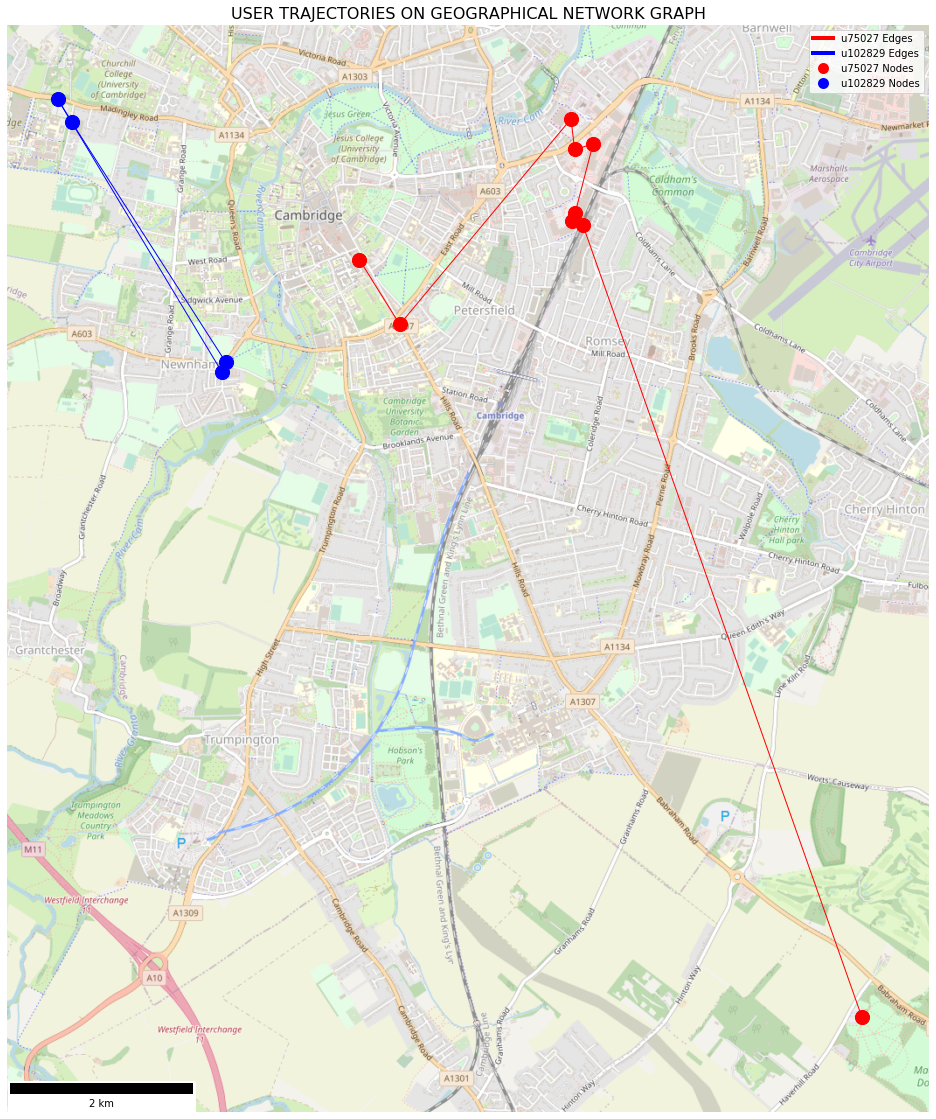

In [11]:
# VISUALISE CHECKINS AS GEOGRAPHICAL NETWORK

# create network graph using check-ins as nodes
def create_network_graph(gdf):
  # create network graph AND add gdf rows as edges
  G = nx.from_pandas_edgelist(gdf, source='orig_id', target='dest_id', edge_attr=True)
  # calculate degree and clustering coefficient for the graph
  deg = nx.degree(G)
  df = pd.DataFrame(list(deg),columns=['char','deg']).set_index('char') # create df with deg attributes
  # # plot graph's deg attributes as histogram
  # df.plot(kind='hist',color='black') # plot as histogram
  # plt.title("Degree Histogram") #  plt.title(title + ": Degree Histogram")
  # plt.ylabel("Count")
  # plt.xlabel("Degree")
  # plt.show()
  # visualise graph's degree attributes
  nx.set_node_attributes(G,dict(deg),'deg') # set node attributes back to graph
  G.nodes(data=True)
  n_color=[(i[1]['deg']) for i in G.nodes(data=True)]
  # calculate weighted degree based on the time between each pair of points
  deg = nx.degree(G, weight='journey_duration')
  nx.set_node_attributes(G,dict(deg),'deg')
  # n_color=[(i[1]['deg']) for i in G.nodes(data=True)]
  return G

u75027_graph = create_network_graph(gdf_geog_u75027_3001_route)
u102829_graph = create_network_graph(gdf_geog_u102829_1105_route)

# lookup projected coordinates of each Loc_ID for use to plot on Contextily basemap 
def create_coord_lookup(gdf):
  gdf_loc_lookup = gdf.drop(['User_ID','date_time', 'lon', 'lat'], axis = 1)        # drop unecessary cols
  gdf_loc_lookup.sort_values("loc_ID", inplace = True)                              # sort rows by loc_ID
  gdf_loc_lookup.drop_duplicates(subset = "loc_ID", keep = 'first', inplace = True) # remove duplicates
  gdf_loc_lookup = gpd.GeoDataFrame(gdf, geometry='geometry')
  gdf_loc_lookup['lon'] = gdf.geometry.x
  gdf_loc_lookup['lat'] = gdf.geometry.y
  gdf_loc_lookup.reset_index(drop=True)                                             # reset previous index
  gdf_loc_lookup = gdf_loc_lookup[['loc_ID', 'lon', 'lat']]                         # reorder cols
  return gdf_loc_lookup

gdf_loc_lookup_proj = create_coord_lookup(gdf_proj)

# plot geographical network graph
def visualise_path(G1, G2, proj_coord_lookup):
  # draw grid for the graph
  figure = plt.figure(figsize=(20,20)) # create figure
  ax = figure.add_subplot(111)         # add plot to figure
  plt.xlabel('longitude')
  plt.ylabel('latitude')
  plt.title("USER TRAJECTORIES ON GEOGRAPHICAL NETWORK GRAPH", fontsize=16)
  plt.rcParams['figure.facecolor'] = 'lightgrey'
  from matplotlib_scalebar.scalebar import ScaleBar
  ax.add_artist(ScaleBar(1, location='lower left'))
  # draw graphs
  pos = {i[1]['loc_ID']:(i[1]['lon'],i[1]['lat']) for i in proj_coord_lookup.iterrows()} # specify coordinates as the graph position
  nx.draw(G1, pos,
          node_color='red', node_size=200,
          width=1, edge_color='red',
          with_labels=False, font_weight='bold', font_color='black',
          ax=ax)
  nx.draw(G2, pos,
          node_color='blue', node_size=200,
          width=1, edge_color='blue',
          with_labels=False, font_weight='bold', font_color='black',
          ax=ax)

  ## generate legend
  ax.plot([], [], "-", c='red', linewidth=4, label='u75027 Edges') # psuedo symbol in legend
  ax.plot([], [], "-", c='blue', linewidth=4, label='u102829 Edges') # pseudo symbol in legend
  ax.plot([], [], "o", c='red', markersize=8, mew=3, label='u75027 Nodes') # pseudo symbol in legend
  ax.plot([], [], "o", c='blue', markersize=8, mew=3, label='u102829 Nodes') # pseudo symbol in legend
  handles, labels = plt.gca().get_legend_handles_labels()
  from collections import OrderedDict
  by_label = OrderedDict(zip(labels, handles))
  plt.legend(by_label.values(), by_label.keys())
  # Add Contextily basemap
  ctx.add_basemap(ax, alpha=0.8, source=ctx.providers.OpenStreetMap.Mapnik)
  plt.show()

visualise_path(u75027_graph, u102829_graph, gdf_loc_lookup_proj)



In [12]:
# NETWORK STATISTICS

# get node from nearest coords
def get_network_routes(gdf, G):
  # compile lists:
  route_list = []
  displacement_list = []
  for index, row in gdf.iterrows(): # for each row in gdf (aka for each partial jouney)
    orig_node = ox.distance.nearest_nodes(G, row['orig_lon'], row['orig_lat']) # get origin node from origin lat/lon
    dest_node = ox.distance.nearest_nodes(G, row['dest_lon'], row['dest_lat']) # get dest node from origin lat/lon
    route_nodes = nx.shortest_path(G, orig_node, dest_node, weight='length') # find all nodes inbetween
    route_list.extend(route_nodes) # add nodes to route list
    orig_to_dest_len = nx.shortest_path_length(G, orig_node, dest_node, weight='length')
    displacement_list.append(orig_to_dest_len)
    # print("from {} to {} is {} ".format(orig_node, dest_node, orig_to_dest_len))
  from itertools import groupby
  route_list = [i[0] for i in groupby(route_list)]  # remove consecutive duplicates for when an end node meets the start of the next.
  # displacement statistics:
  max_displacement = max(displacement_list)
  from statistics import mean
  avg_displacement = mean(displacement_list)
  tot_displacement = sum(displacement_list)
  return route_list, displacement_list, max_displacement, avg_displacement, tot_displacement

u75027_route_list, u75027_displacement_list, u75027_max_displacement, u75027_avg_displacement, u75027_tot_displacement = get_network_routes(gdf_geog_u75027_3001_route, cambridge_graph)
u102829_route_list, u102829_displacement_list, u102829_max_displacement, u102829_avg_displacement, u102829_tot_displacement = get_network_routes(gdf_geog_u102829_1105_route, cambridge_graph)
routes = [u75027_route_list, u102829_route_list]  # make list of route lists

# list of intercepted nodes:
print("\nIntercepted nodes for u75027: ", u75027_route_list)
print("Intercepted nodes for u102829: ", u102829_route_list)

# list of displacements:
print("\nDisplacement list for u75027: ", u75027_displacement_list)
print("Displacement list for u102829: ", u102829_displacement_list)

# maximum distance between two consecutive locations they moved between
print("\nMax Displacement by u75027: ", u75027_max_displacement)
print("Max Displacement by u102829: ", u102829_max_displacement)

# average distance between two consecutive locations/check-ins
print("\nAverage Displacement by u75027: ", u75027_avg_displacement)
print("Average Displacement by u102829: ", u102829_avg_displacement)

# total distance travelled on the day
print("\nTotal Displacement by u75027: ", u75027_tot_displacement)
print("Total Displacement by u102829: ", u102829_tot_displacement)


Intercepted nodes for u75027:  [291665147, 292591040, 291665146, 291923509, 26531999, 292594606, 26532005, 26530868, 26532006, 7826125129, 3718157166, 8682592381, 26355221, 26355222, 26355223, 554191, 554194, 554195, 554196, 554197, 554198, 554199, 554200, 554201, 554202, 554203, 554204, 554205, 3131643844, 1476526509, 5833553410, 704487546, 678337800, 5833553409, 5833553419, 704487548, 678337803, 678337791, 5833553414, 678337809, 730214058, 554224, 4211887098, 554245, 554246, 4211887108, 554247, 4211887111, 5244989483, 554248, 5244989473, 554249, 554250, 554251, 554252, 554253, 554254, 9483451605, 554255, 623408192, 9483451601, 9405519178, 9405519173, 554257, 554258, 554259, 554260, 554261, 554262, 7580828063, 554263, 554264, 673845809, 4540003222, 554265, 25288278, 25288585, 554283, 554282, 725608506, 554272, 2397539025, 21391155, 554271, 482307363, 2397539024, 696653605, 725608497, 554270, 482307373, 554269, 554279, 725608487, 554280, 725608491, 2397539019, 554286, 5457750235, 2397

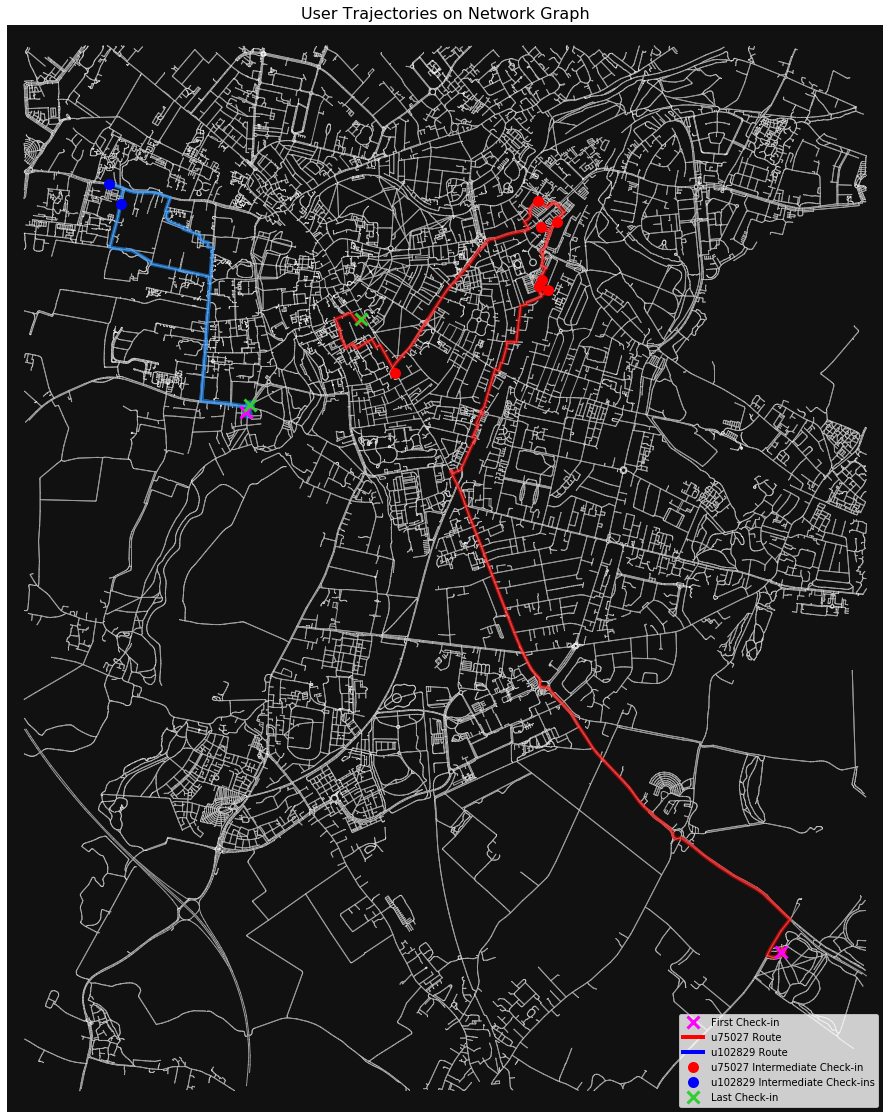

In [13]:
# PLOT ROUTES ON OSM NETWORK GRAPH
def routes_on_network(G, routes, gdf):
  rc = ['red', 'dodgerblue']
  fig, ax = ox.plot_graph_routes(G, routes, route_colors=rc, figsize=(20,20), node_size=0.5, show=False, close=False, route_linewidth=5, route_alpha=0.6, orig_dest_size=100, ax=None)
  plt.title("User Trajectories on Network Graph", fontsize=16)
  # plot origin, intermediate and destination points
  ax.plot(gdf[gdf['user_id'] == 75027].iloc[0]['orig_lon'], gdf[gdf['user_id'] == 75027].iloc[0]['orig_lat'], "x", c='magenta', markersize=12, mew=3, label='First Check-in') # origin
  ax.plot(gdf[gdf['user_id'] == 102829].iloc[0]['orig_lon'], gdf[gdf['user_id'] == 102829].iloc[0]['orig_lat'], "x", c='magenta', markersize=12, mew=3, label='First Check-in') # origin
  ax.plot([], [], "-", c='red', linewidth=4, label='u75027 Route') # psuedo plot to show relavent symbol in legend
  ax.plot([], [], "-", c='blue', linewidth=4, label='u102829 Route') # pseudo plot to show relavent symbol in legend
  ax.plot(gdf[gdf['user_id'] == 75027].iloc[0:-1]['dest_lon'], gdf[gdf['user_id'] == 75027].iloc[0:-1]['dest_lat'], "o", c='red', markersize=8, mew=3, label='u75027 Intermediate Check-in') # intermediate
  ax.plot(gdf[gdf['user_id'] == 102829].iloc[0:-1]['dest_lon'], gdf[gdf['user_id'] == 102829].iloc[0:-1]['dest_lat'], "o", c='blue', markersize=8, mew=3, label='u102829 Intermediate Check-ins') # intermediate
  ax.plot(gdf[gdf['user_id'] == 75027].iloc[-1]['dest_lon'], gdf[gdf['user_id'] == 75027].iloc[-1]['dest_lat'], "x", c='limegreen', markersize=12, mew=3, label='Last Check-in') # destination
  ax.plot(gdf[gdf['user_id'] == 102829].iloc[-1]['dest_lon'], gdf[gdf['user_id'] == 102829].iloc[-1]['dest_lat'], "x", c='limegreen', markersize=12, mew=3, label='Last Check-in') # destination
  # generate legend
  handles, labels = plt.gca().get_legend_handles_labels()
  from collections import OrderedDict
  by_label = OrderedDict(zip(labels, handles))
  plt.legend(by_label.values(), by_label.keys())
  plt.show()

routes = [u75027_route_list, u102829_route_list]  # make list of route lists
routes_on_network(cambridge_graph, routes, gdf_geog_stacked_route)

In [ ]:
# PLOT ROUTES ON OSM NETWORK GRAPH USING FOLIUM
def routes_on_folium(gdf, route1, route2, G):

  trajectories_map = Map([gdf['geometry'].y.mean(), gdf['geometry'].x.mean()], tiles='OpenStreetMap', zoom_start=13)
  
  # first child: route
  fg = FeatureGroup(name='legend name', show=False)
  ox.plot_route_folium(G, route1, route_color='red', route_map=fg)
  ox.plot_route_folium(G, route2, route_color='blue', route_map=fg)
  trajectories_map.add_child(fg)

  # second child: point markers
  userID_list = gdf['User_ID'].tolist()
  geometry_list = [(point.xy[1][0], point.xy[0][0]) for point in gdf.geometry ]
  for user, point in zip(userID_list, geometry_list): # loop through multiple lists sequentially
    if user == 75027:
      type_color = "darkred"
    elif user == 102829:
      type_color = "darkblue"
    else:
      continue
    
    # specify marker symbols and add to map
    trajectories_map.add_child(folium.Marker(location = point, icon = folium.Icon(color= "%s" % type_color, icon='user', prefix='fa'), popup =
                              "User: " + '<br>' + str(user) + '<br> <br>'
                              "DateTime: " + '<br>' + str("datetime") + '<br> <br>'
                              "Lat: " + '<br>' + str(point[0]) + '<br>'
                              "Long: " + '<br>' + str(point[1]) + '<br>'
                              )) # Place the markers with the popup labels and data.
  display(trajectories_map)
  return trajectories_map

trajectories_map = routes_on_folium(gdf_geog_stacked, u75027_route_list, u102829_route_list, cambridge_graph)
trajectories_map.save("Traj_on_Folium.html")

/usr/local/lib/python3.7/dist-packages/osmnx/folium.py:126: UserWarning: `route_color` has been deprecated and will be removed: use kwargs instead
  warn("`route_color` has been deprecated and will be removed: use kwargs instead")


---
**2.2.3 Comparative analysis of check-in frequencies and network centrality**

Describe the general pattern of user check-ins in the Gowalla dataset in relation to closeness centrality measure for the City of Cambridge, UK, using whatever visual aids you see as fitting to your analysis. Comment on any observable trends which you find most noticeable and/or interesting.

In [ ]:
# Find Closeness Centrality for 'City of Cambridge'
# inspiration: https://colab.research.google.com/github/tommylouistaylor/GEOG0051-DataMining/blob/main/Week03-Street_Network_Analysis_and_Urban_Design/GEOG0051_Lab3%20(Answers).ipynb/GEOG0051_Lab3%20(Answers).ipynb#scrollTo=T0doPbCahloV
def prepare_cc_graph():
  from shapely.geometry import Point  #Polygon
  cambridge_boundary = ox.geocode_to_gdf('Cambridge,UK')
  polygon = cambridge_boundary.iloc[0]['geometry']
  # G = ox.graph_from_polygon(polygon, network_type='walk', simplify=False)
  G = ox.graph.graph_from_address('Cambridge,UK', dist=1000, # geocodes the address string to retrieve the place boundaries via a DataAPI
                                dist_type='bbox', # retains nodes within a bounding box of the distance parameter
                                network_type='all' ,
                                simplify=False, retain_all=False, truncate_by_edge=False, return_coords=False, clean_periphery=True, custom_filter=None)  
  DG = ox.get_digraph(G) # set as diGraph, as some measures not implemented on multiGraph.
  edge_cc = nx.closeness_centrality(nx.line_graph(DG)) # convert graph to a line graph (edges become nodes)
  nx.set_edge_attributes(DG,edge_cc,'cc') # inscribe centrality measure of each node as an edge attribute
  G1 = nx.MultiGraph(DG)
  # convert graph to gdf
  gdf_edges = ox.graph_to_gdfs(G1, nodes=False, fill_edge_geometry=True)
  gdf_edges = gdf_edges.to_crs(epsg=3857) # set crs to 3857 for contextily
  return G1, gdf_edges, cambridge_boundary

G1, gdf_edges, cambridge_boundary = prepare_cc_graph()
# multiGraph_2 = prepare_graph('network')

In [ ]:
# CLIP POINTS BY GEOMETRY OF BOUNDARY
# clip check-in points by city of Cambridge Boundary
def points_inside_boundary(gdf, bbox):
  from shapely.geometry import Point, Polygon  #Polygon
  min_x, min_y, max_x, max_y = bbox.geometry.total_bounds
  bounding_xs = [min_x, min_x, max_x, max_x]
  bounding_ys = [min_y, max_y, max_y, min_y]
  mbr_category = []
  for x, y in zip(gdf.lon, gdf.lat):
    if x < min_x or x > max_x or y < min_y or y > max_y:
        mbr_category.append('outside')
    else:
        mbr_category.append('inside')
  gdf['mbr_category'] = mbr_category
  gdf_geog_withinBound = gdf[gdf.mbr_category=='inside'] # select points within boundary ('True')
  return gdf_geog_withinBound, cambridge_boundary

gdf_proj_withinBound, cambridge_boundary = points_inside_boundary(gdf_proj, gdf_edges)
# print(gdf_proj_withinBound.to_string())

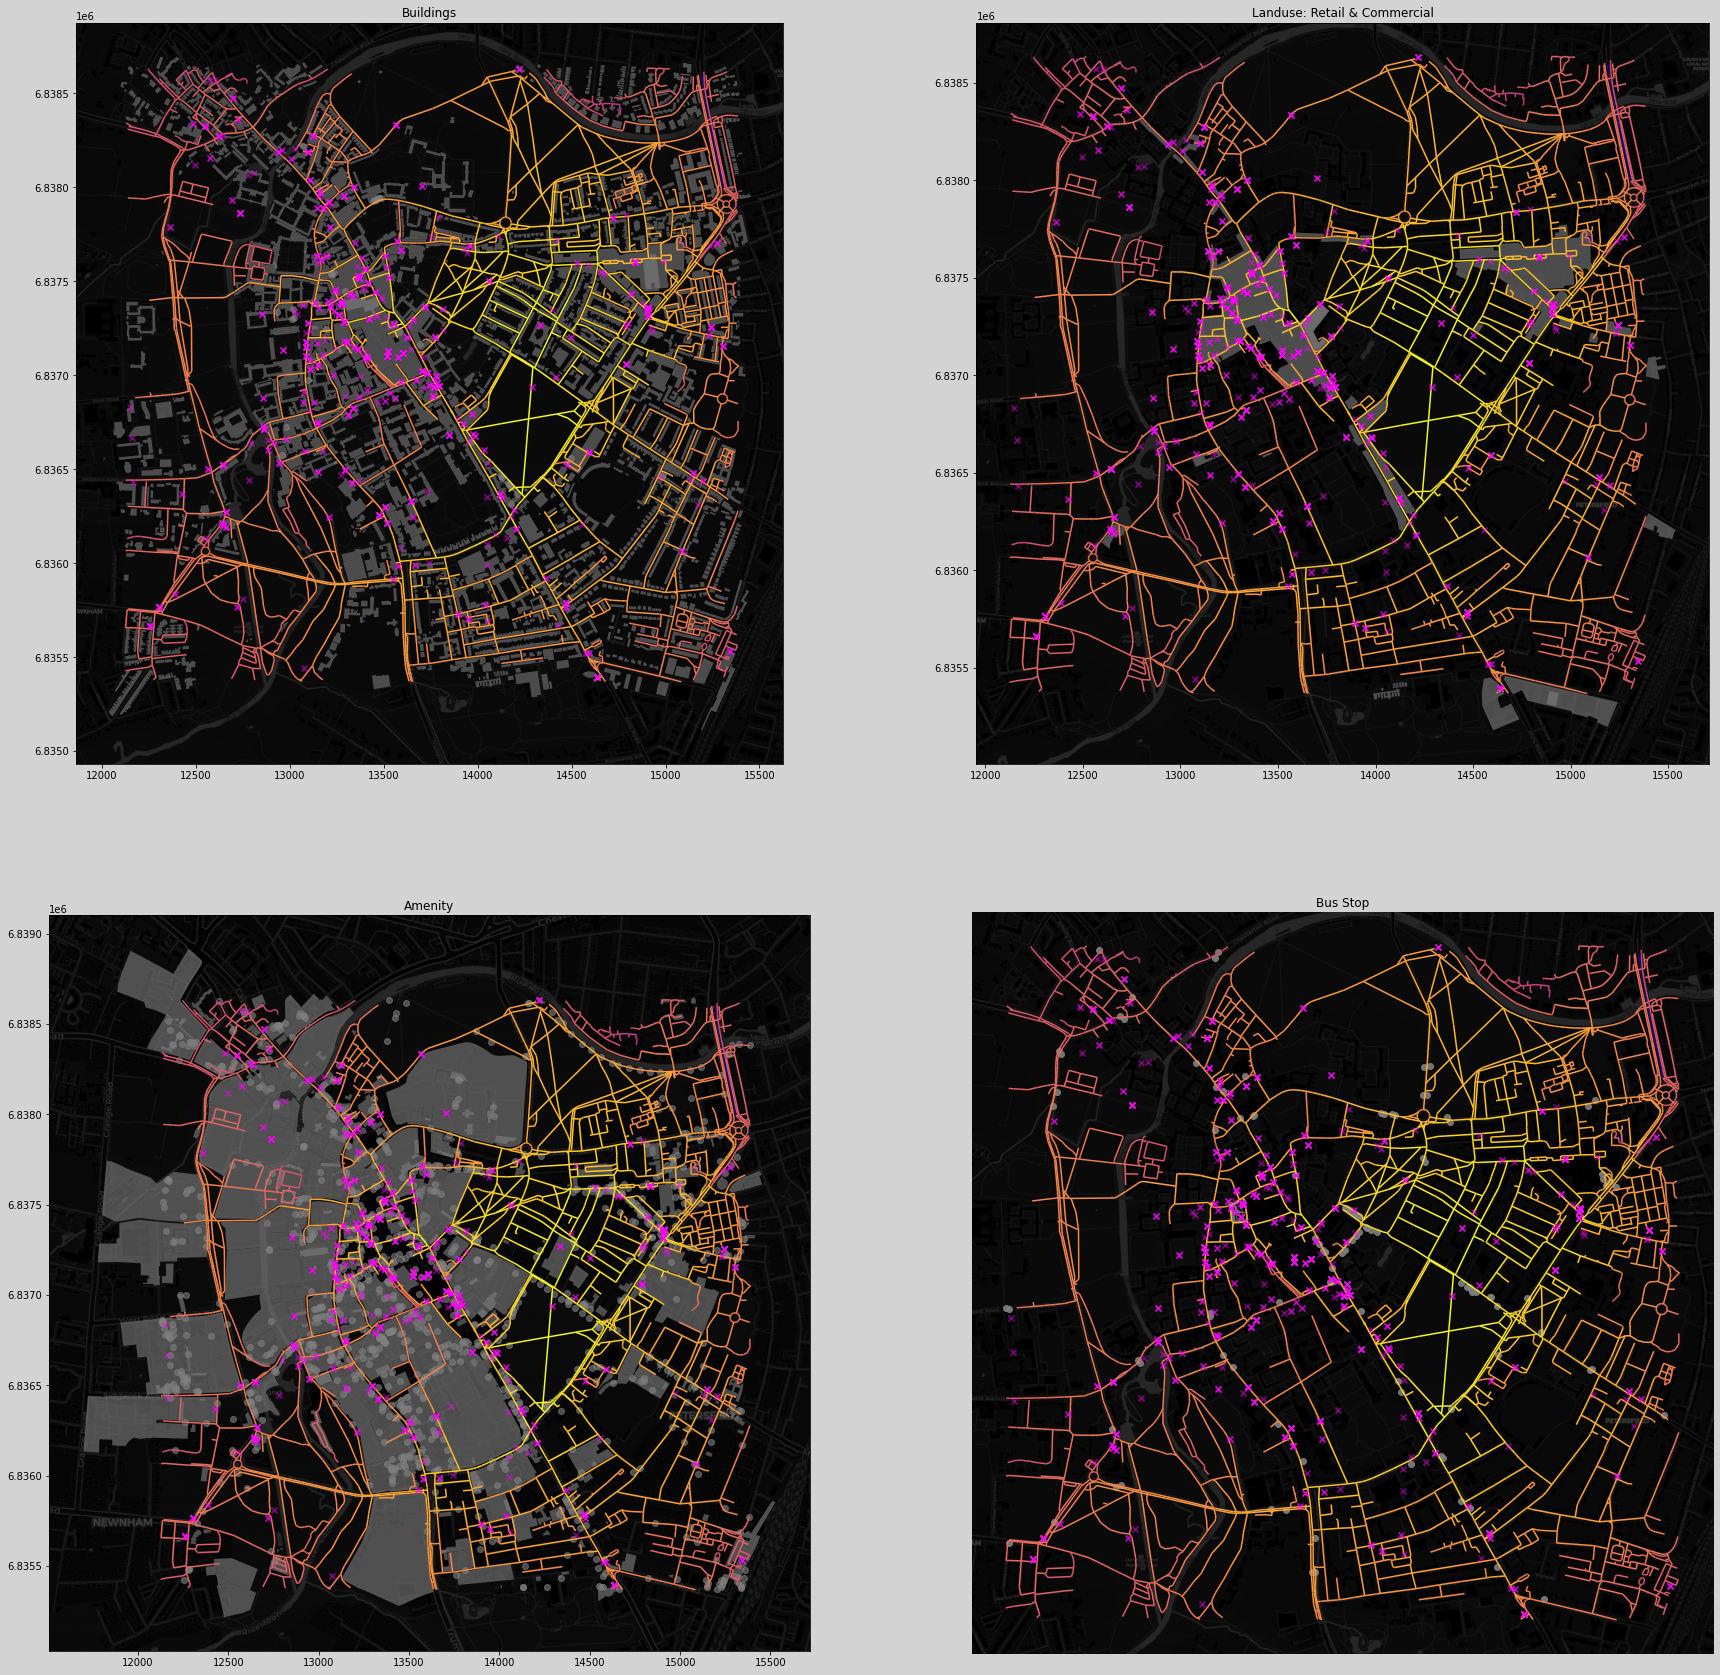

In [ ]:
def plot_cc(G1, gdf, boundary, gdf_edges):
  fig = plt.figure(figsize=(30,30))
  ax1 = fig.add_subplot(221)
  ax2 = fig.add_subplot(222)
  ax3 = fig.add_subplot(223)
  ax4 = fig.add_subplot(224)
  plt.rcParams['figure.facecolor'] = 'lightgrey'
  plt.rcParams['savefig.dpi'] = 300
  plt.title("MAPPING CLOSENESS CENTRALITY, CHECK-INS & SPACE TOPOLOGIES", fontsize=25)

  # fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
  ax1 = gdf_edges.plot('cc', cmap='plasma', figsize=(18,18), ax=ax1)
  ax1.set_title('Buildings')
  ax2 = gdf_edges.plot('cc', cmap='plasma', figsize=(18,18), ax=ax2)
  ax2.set_title('Landuse: Retail & Commercial')
  ax3 = gdf_edges.plot('cc', cmap='plasma', figsize=(18,18), ax=ax3)
  ax3.set_title('Amenity')
  ax4 = gdf_edges.plot('cc', cmap='plasma', figsize=(18,18), ax=ax4)
  ax4.set_title('Bus Stop')

  # you can get the geometries of a place similar to getting a graph 
  tags = {'building': True, 'amenity':True, 'landuse':['retail','commercial'], 'highway':'bus_stop'}
  all_geom=ox.geometries.geometries_from_address('Cambridge,UK', tags, dist=1000)
  all_geom = all_geom.to_crs(epsg=3857)
  all_geom[all_geom['building'].notna()].plot(ax=ax1,color='grey', alpha=0.6)
  all_geom[all_geom['landuse'].notna()].plot(ax=ax2,color='grey', alpha=0.6)
  all_geom[all_geom['amenity'].notna()].plot(ax=ax3,color='grey', alpha=0.6)
  all_geom[all_geom['highway'].notna()].plot(ax=ax4,color='grey', alpha=0.9)

  # plot checkins
  gdf.plot(ax=ax1, alpha=0.5, marker='x', color='magenta', markersize=35, zorder=100) # REMOVE POINTS OUTSIDE BBOX
  gdf.plot(ax=ax2, alpha=0.5, marker='x', color='magenta', markersize=35, zorder=100) # REMOVE POINTS OUTSIDE BBOX
  gdf.plot(ax=ax3, alpha=0.5, marker='x', color='magenta', markersize=35, zorder=100) # REMOVE POINTS OUTSIDE BBOX
  gdf.plot(ax=ax4, alpha=0.5, marker='x', color='magenta', markersize=35, zorder=100) # REMOVE POINTS OUTSIDE BBOX

  # add contextily basemap
  ctx.add_basemap(ax1, source=ctx.providers.CartoDB.DarkMatter)
  ctx.add_basemap(ax2, source=ctx.providers.CartoDB.DarkMatter)
  ctx.add_basemap(ax3, source=ctx.providers.CartoDB.DarkMatter)
  ctx.add_basemap(ax4, source=ctx.providers.CartoDB.DarkMatter)
  
  plt.axis('off')
  plt.show()

plot_cc(G1, gdf_proj_withinBound, cambridge_boundary, gdf_edges)
# plot_cc(multiGraph_2, geometry_list_proj)

---
**2.2.4 Urban Planning Application Question**

Imagine that you were taking the role of a consultant to the authorities in Cambridge responsible for urban planning. Choose one of the following urban features and propose a new location where you would build that feature: museum, shopping mall, fire station, community park. Use the outputs of your analysis from the task above (2.2.3) and any relevant knowledge of the local area to justify your decision.

*Note: You do not have to do any further analysis/visualisation by code. However, if you feel like your response could benefit from further analysis, you can choose to briefly describe what accompanying analysis you would undertake.*